# gRNA Classification - Baseline Models

This notebook demonstrates:
1. Data preparation (positive and negative examples)
2. Feature extraction
3. Training baseline ML models (Random Forest & XGBoost)
4. Model evaluation and comparison

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from grna_inspector.data_preparation import gRNADataPreparator
from grna_inspector.baseline_models import gRNABaselineClassifier, compare_models

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

%load_ext autoreload
%autoreload 2

## 1. Data Preparation

Load positive examples (canonical gRNA) and generate negative examples from:
- Inter-cassette regions
- Maxicircle sequences
- Shuffled sequences

In [2]:
# Initialize data preparator
data_dir = Path('../data')
preparator = gRNADataPreparator(data_dir)

# Prepare datasets
train_df, val_df, test_df = preparator.prepare_dataset(
    test_size=0.15,
    val_size=0.15,
    balance_ratio=1.0,  # 1:1 ratio of positives to negatives
    random_state=42
)


PREPARING gRNA CLASSIFICATION DATASET

Loading positive examples (canonical gRNA)...
  Loaded 1158 canonical gRNA sequences
Extracting inter-cassette regions...
  Extracted 1104 inter-cassette sequences
Extracting maxicircle sequences...
  Extracted 500 maxicircle sequences
Generating shuffled sequences...
  Generated 300 shuffled sequences

Dataset composition:
  Positives: 1158
  Negatives: 1158
  Ratio: 1:1.00
Computing sequence features...
  Computed 1158 feature vectors with 43 features each
Computing sequence features...
  Computed 1158 feature vectors with 43 features each

Dataset splits:
  Train: 1622 (811 pos, 811 neg)
  Val:   347 (166 pos, 181 neg)
  Test:  347 (181 pos, 166 neg)

Datasets saved to ../data/processed



## 2. Explore Dataset

In [3]:
# Dataset statistics
print("Train set shape:", train_df.shape)
print("Val set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

print("\nFeature columns:")
feature_cols = [col for col in train_df.columns if col not in ['sequence_id', 'label', 'source', 'sequence']]
print(f"Total features: {len(feature_cols)}")
print(feature_cols[:10], "...")

Train set shape: (1622, 47)
Val set shape: (347, 47)
Test set shape: (347, 47)

Feature columns:
Total features: 43
['length', 'a_content', 't_content', 'g_content', 'c_content', 'gc_content', 'at_content', 'purine_content', 'dinuc_AA', 'dinuc_AT'] ...


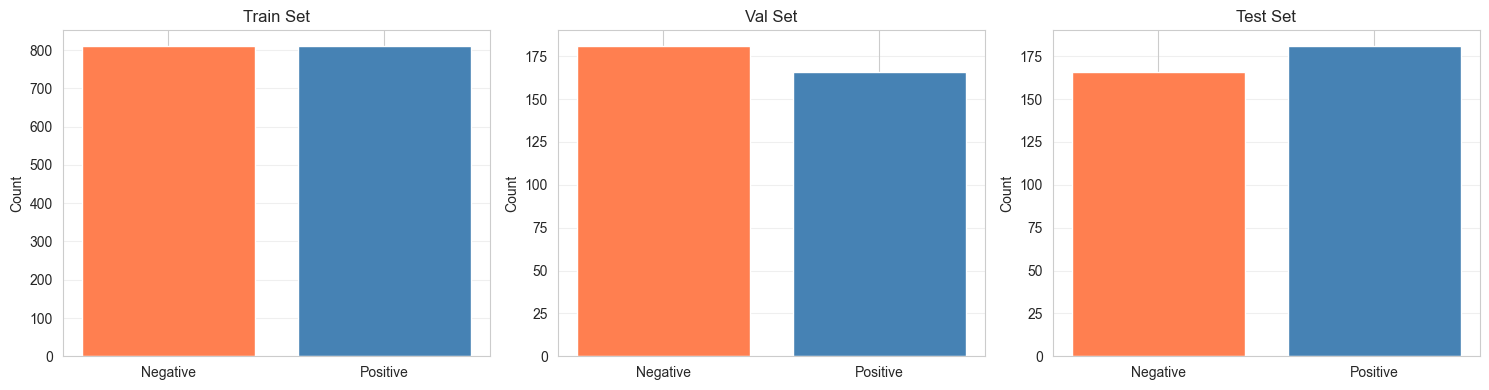

In [4]:
# Plot class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, df) in zip(axes, [('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    counts = df['label'].value_counts()
    ax.bar(['Negative', 'Positive'], [counts[0], counts[1]], color=['coral', 'steelblue'])
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Set')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

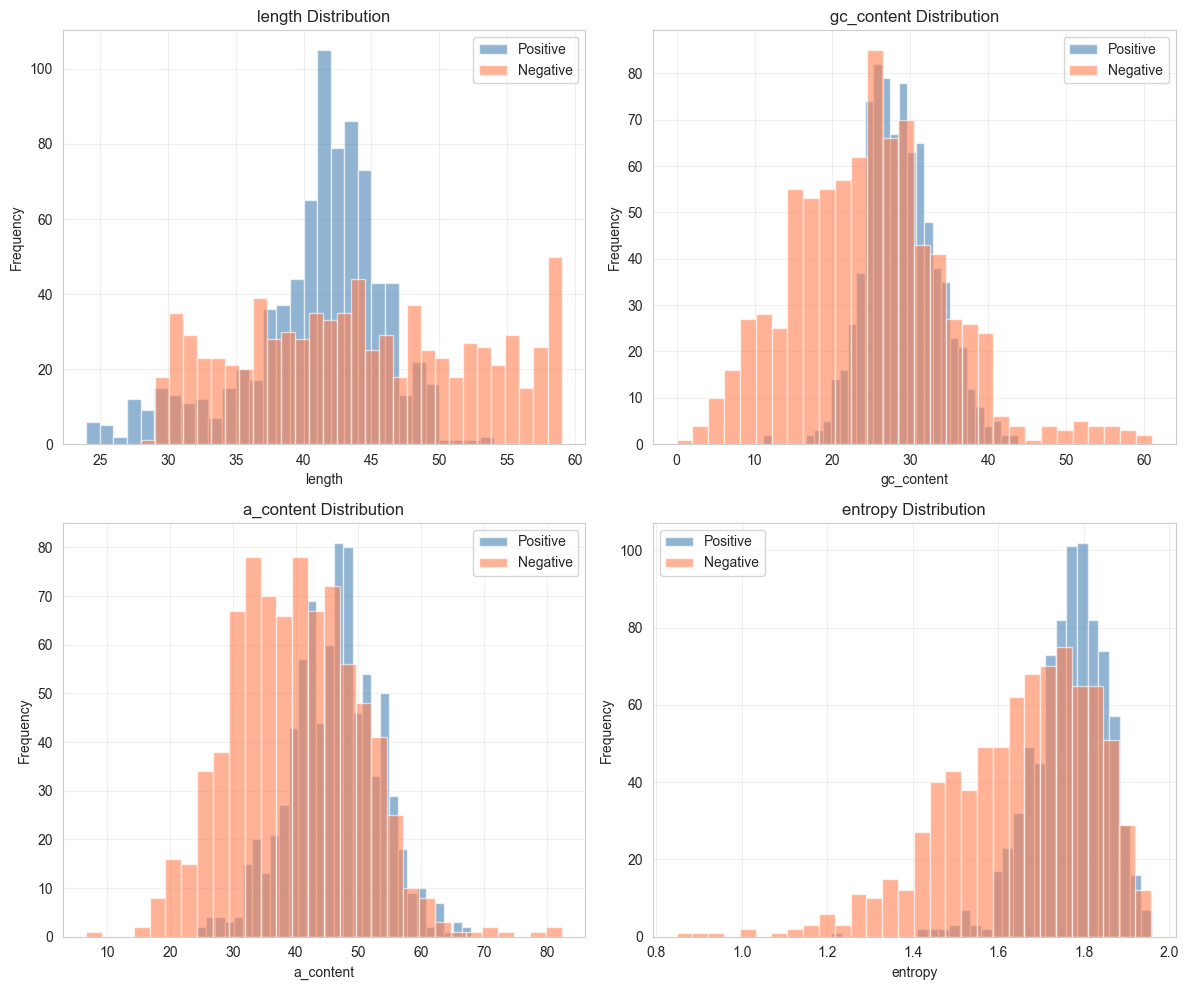

In [5]:
# Plot feature distributions for key features
key_features = ['length', 'gc_content', 'a_content', 'entropy']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, feature in zip(axes, key_features):
    train_df[train_df['label']==1][feature].hist(ax=ax, bins=30, alpha=0.6, label='Positive', color='steelblue')
    train_df[train_df['label']==0][feature].hist(ax=ax, bins=30, alpha=0.6, label='Negative', color='coral')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/plots/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Train Baseline Models

### 3.1 Random Forest

In [6]:
# Train Random Forest
rf_classifier = gRNABaselineClassifier(model_type='random_forest', random_state=42)
rf_classifier.train(train_df, val_df)


TRAINING RANDOM_FOREST CLASSIFIER

Training set: 1622 samples, 43 features
Class distribution: 811 positive, 811 negative


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.1s



Training complete!

Training Results:
  Accuracy:    0.9753
  Precision:   0.9684
  Recall:      0.9827
  F1-score:    0.9755
  ROC-AUC:     0.9976
  Specificity: 0.9679

Confusion Matrix:
  TN:  785  FP:   26
  FN:   14  TP:  797

Validation Results:
  Accuracy:    0.8934
  Precision:   0.8644
  Recall:      0.9217
  F1-score:    0.8921
  ROC-AUC:     0.9566
  Specificity: 0.8674

Confusion Matrix:
  TN:  157  FP:   24
  FN:   13  TP:  153


[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | 

In [7]:
# Evaluate on test set
rf_test_metrics = rf_classifier.evaluate(test_df, dataset_name='Test')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s



Test Results:
  Accuracy:    0.8934
  Precision:   0.9000
  Recall:      0.8950
  F1-score:    0.8975
  ROC-AUC:     0.9584
  Specificity: 0.8916

Confusion Matrix:
  TN:  148  FP:   18
  FN:   19  TP:  162


[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished


Feature importance plot saved to ../data/plots/rf_feature_importance.png


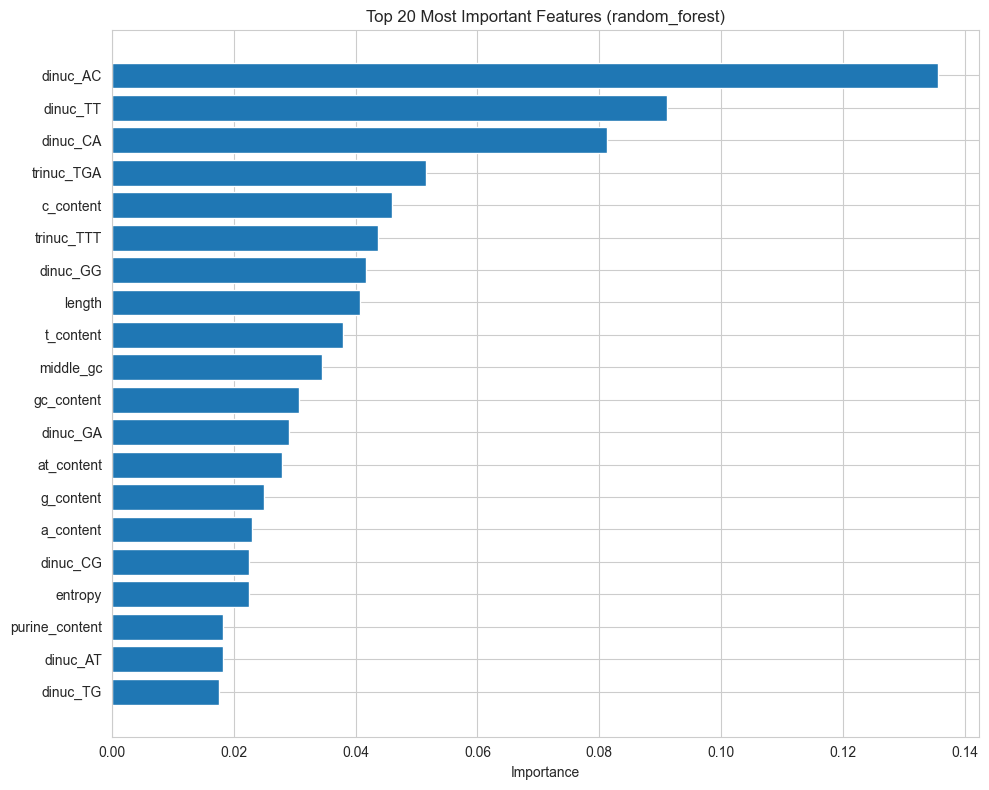

In [8]:
# Feature importance
rf_classifier.plot_feature_importance(top_n=20, save_path=Path('../data/plots/rf_feature_importance.png'))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s


ROC curve saved to ../data/plots/rf_roc_curve.png


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished


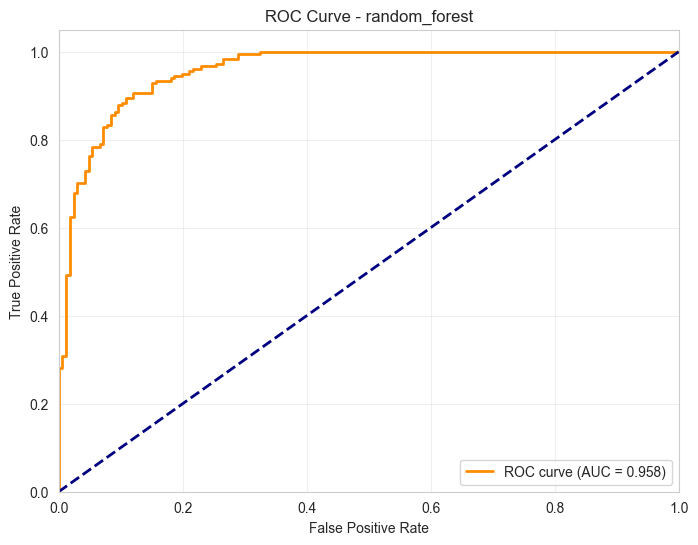

In [9]:
# ROC curve
rf_classifier.plot_roc_curve(test_df, save_path=Path('../data/plots/rf_roc_curve.png'))

### 3.2 XGBoost

In [10]:
# Train XGBoost
xgb_classifier = gRNABaselineClassifier(model_type='xgboost', random_state=42)
xgb_classifier.train(train_df, val_df)


TRAINING XGBOOST CLASSIFIER

Training set: 1622 samples, 43 features
Class distribution: 811 positive, 811 negative
  Note: Training without early stopping for compatibility

Training complete!

Training Results:
  Accuracy:    1.0000
  Precision:   1.0000
  Recall:      1.0000
  F1-score:    1.0000
  ROC-AUC:     1.0000
  Specificity: 1.0000

Confusion Matrix:
  TN:  811  FP:    0
  FN:    0  TP:  811

Validation Results:
  Accuracy:    0.9280
  Precision:   0.9222
  Recall:      0.9277
  F1-score:    0.9249
  ROC-AUC:     0.9741
  Specificity: 0.9282

Confusion Matrix:
  TN:  168  FP:   13
  FN:   12  TP:  154


In [12]:
# Evaluate on test set
xgb_test_metrics = xgb_classifier.evaluate(test_df, dataset_name='Test')


Test Results:
  Accuracy:    0.9251
  Precision:   0.9144
  Recall:      0.9448
  F1-score:    0.9293
  ROC-AUC:     0.9751
  Specificity: 0.9036

Confusion Matrix:
  TN:  150  FP:   16
  FN:   10  TP:  171


Feature importance plot saved to ../data/plots/xgb_feature_importance.png


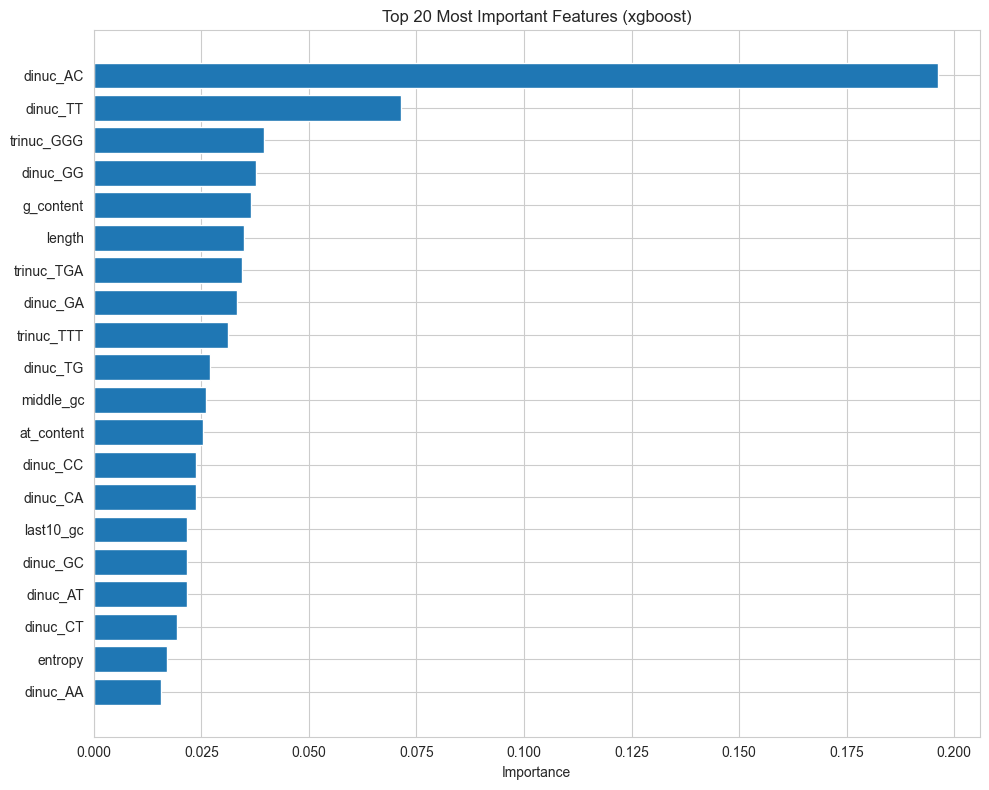

In [13]:
# Feature importance
xgb_classifier.plot_feature_importance(top_n=20, save_path=Path('../data/plots/xgb_feature_importance.png'))

ROC curve saved to ../data/plots/xgb_roc_curve.png


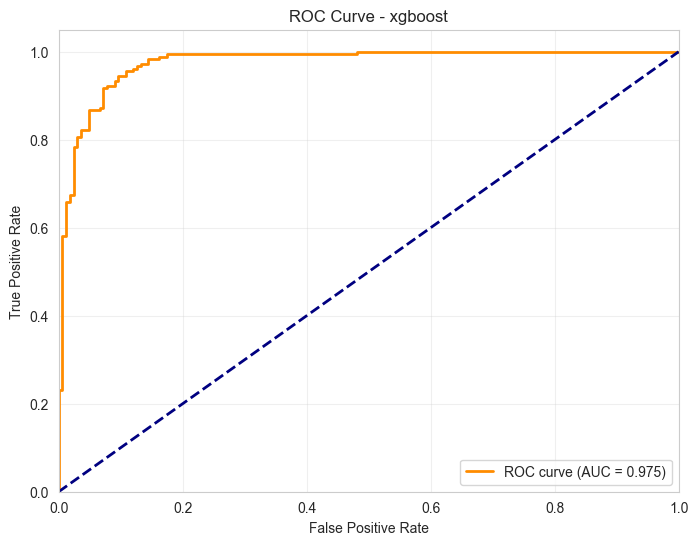

In [14]:
# ROC curve
xgb_classifier.plot_roc_curve(test_df, save_path=Path('../data/plots/xgb_roc_curve.png'))

## 4. Model Comparison

In [15]:
# Compare models side by side
comparison_df = pd.DataFrame({
    'Random Forest': rf_test_metrics,
    'XGBoost': xgb_test_metrics
}).T

print("\nModel Comparison on Test Set:")
print(comparison_df.round(4))


Model Comparison on Test Set:
               accuracy  precision  recall      f1  roc_auc  true_positives  \
Random Forest    0.8934     0.9000  0.8950  0.8975   0.9584           162.0   
XGBoost          0.9251     0.9144  0.9448  0.9293   0.9751           171.0   

               true_negatives  false_positives  false_negatives  specificity  
Random Forest           148.0             18.0             19.0       0.8916  
XGBoost                 150.0             16.0             10.0       0.9036  


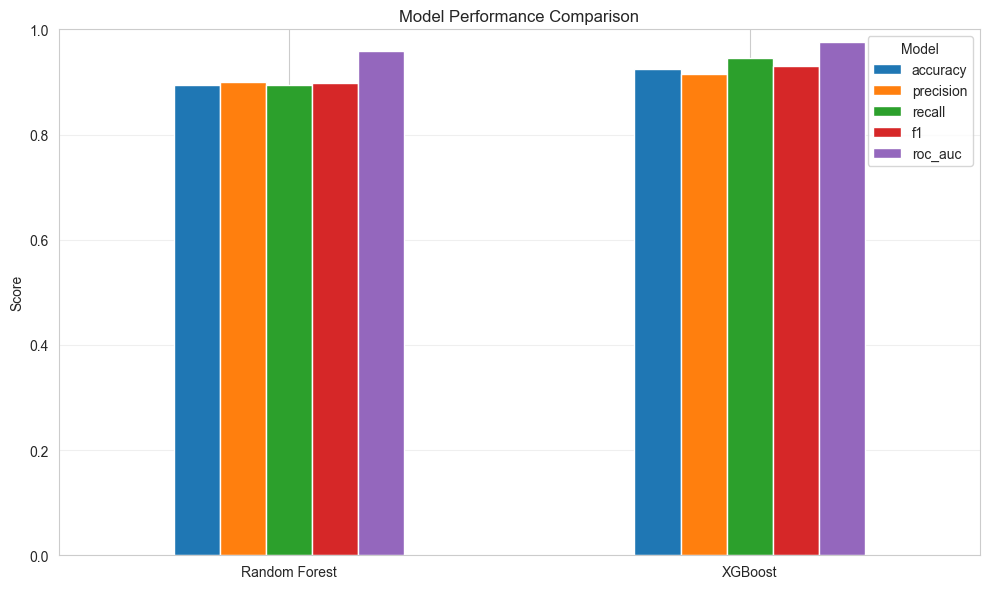

In [16]:
# Plot comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_subset = comparison_df[metrics_to_plot]

ax = comparison_subset.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Save Best Model

In [17]:
# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save both models
rf_classifier.save_model(models_dir / 'rf_grna_classifier.joblib')
xgb_classifier.save_model(models_dir / 'xgb_grna_classifier.joblib')

print("Models saved!")

Model saved to ../models/rf_grna_classifier.joblib
Model saved to ../models/xgb_grna_classifier.joblib
Models saved!


## 6. Test Predictions on New Sequences

In [18]:
# Example: predict on a few sequences
test_sequences = [
    test_df[test_df['label']==1]['sequence'].iloc[0],  # Real gRNA
    test_df[test_df['label']==0]['sequence'].iloc[0],  # Negative example
]

predictions, probabilities = xgb_classifier.predict(test_sequences)

for i, (seq, pred, prob) in enumerate(zip(test_sequences, predictions, probabilities)):
    print(f"\nSequence {i+1}: {seq[:50]}...")
    print(f"  Prediction: {'gRNA' if pred == 1 else 'Not gRNA'}")
    print(f"  Probability: {prob:.4f}")

Computing sequence features...
  Computed 2 feature vectors with 43 features each

Sequence 1: CAACTGCAAGATCGTGTTATAGAGGATAAGTGATT...
  Prediction: gRNA
  Probability: 0.9911

Sequence 2: TAGAGAGAAGGATTGAGTAATAGATATAGATTTAAATATCATATAATTAT...
  Prediction: Not gRNA
  Probability: 0.0004


## 7. Error Analysis

In [19]:
# Get predictions on test set
feature_cols = [col for col in test_df.columns if col not in ['sequence_id', 'label', 'source', 'sequence']]
X_test = test_df[feature_cols].values
y_test = test_df['label'].values

y_pred = xgb_classifier.model.predict(X_test)
y_proba = xgb_classifier.model.predict_proba(X_test)[:, 1]

# Add predictions to test_df
test_df['prediction'] = y_pred
test_df['probability'] = y_proba

# Analyze false positives
false_positives = test_df[(test_df['label'] == 0) & (test_df['prediction'] == 1)]
print(f"\nFalse Positives: {len(false_positives)}")
print("Sources:")
print(false_positives['source'].value_counts())

# Analyze false negatives
false_negatives = test_df[(test_df['label'] == 1) & (test_df['prediction'] == 0)]
print(f"\nFalse Negatives: {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nCharacteristics of false negatives:")
    print(false_negatives[['length', 'gc_content', 'a_content', 'probability']].describe())


False Positives: 16
Sources:
source
shuffled          10
inter_cassette     4
maxicircle         2
Name: count, dtype: int64

False Negatives: 10

Characteristics of false negatives:
          length  gc_content  a_content  probability
count  10.000000   10.000000  10.000000    10.000000
mean   37.900000   24.399886  44.268483     0.226736
std     7.202623    6.970887   7.495446     0.118253
min    25.000000   16.000000  27.027027     0.002456
25%    32.500000   19.866704  41.000000     0.155877
50%    39.500000   23.820513  45.695971     0.220413
75%    41.750000   27.172619  49.695122     0.303574
max    50.000000   37.837838  51.612903     0.392580


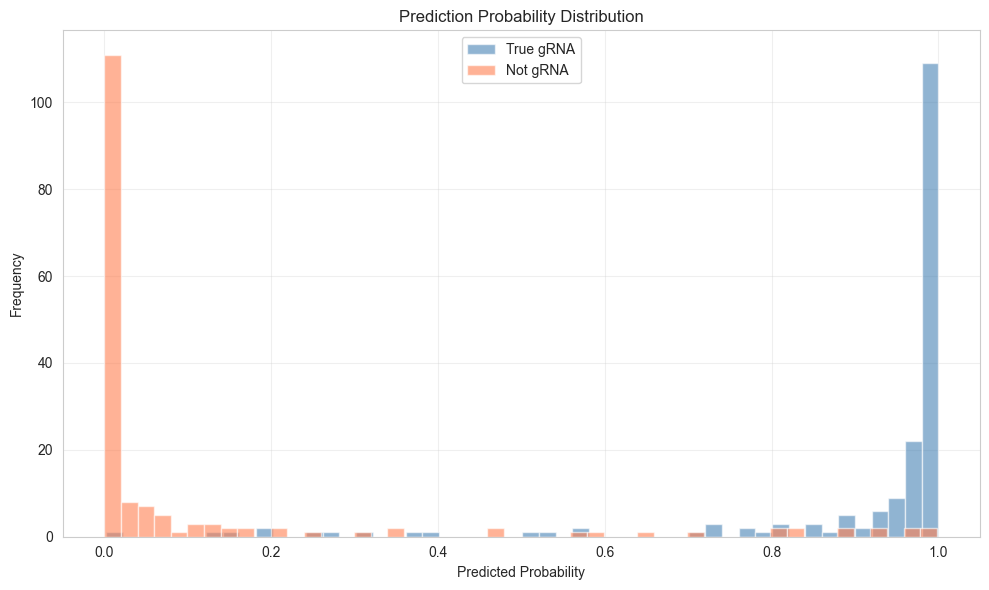

In [20]:
# Plot probability distributions
fig, ax = plt.subplots(figsize=(10, 6))

test_df[test_df['label']==1]['probability'].hist(ax=ax, bins=50, alpha=0.6, label='True gRNA', color='steelblue')
test_df[test_df['label']==0]['probability'].hist(ax=ax, bins=50, alpha=0.6, label='Not gRNA', color='coral')

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Frequency')
ax.set_title('Prediction Probability Distribution')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/plots/probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

This notebook demonstrated:
1. ✅ Data preparation with balanced positive/negative examples
2. ✅ Feature extraction (composition, k-mers, motifs)
3. ✅ Training and evaluation of baseline ML models
4. ✅ Model comparison and selection
5. ✅ Error analysis

**Next steps:**
- Implement deep learning models (CNN-LSTM)
- Multi-class classification (canonical vs non-canonical)
- Transfer learning to other species